In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as scio
import scipy.optimize as opt

In [2]:
# ===================== Part 1: Loading movie ratings dataset =====================

Text(0, 0.5, 'Movies')

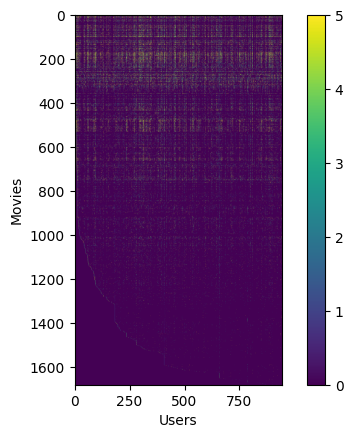

In [3]:
# Load data
data = scio.loadmat('ex8_movies.mat')
Y = data['Y']
R = data['R']

# Y is a 1682 x 943 2-d ndarray, containing ratings 1-5 of 1682 movies on 943 users
#
# R is a 1682 x 943 2-d ndarray, where R[i, j] = 1 if and only if user j gave a
# rating to movie i

# We can visualize the ratings matrix by plotting it with plt.imshow
plt.figure()
plt.imshow(Y)
plt.colorbar()
plt.xlabel('Users')
plt.ylabel('Movies')

In [5]:
# ===================== Part 2: Collaborative Filtering Cost function =====================
data = scio.loadmat('ex8_movieParams.mat')
X = data['X']
theta = data['Theta']
num_users = data['num_users']
num_movies = data['num_movies']
num_features = data['num_features']

In [50]:
def cofi_cost_function(params, Y, R, num_users, num_movies, num_features, lmd):
    X = params[0:num_movies * num_features].reshape((num_movies, num_features))
    theta = params[num_movies * num_features:].reshape((num_users, num_features))

    # You need to set the following values correctly.
    cost = 0
    X_grad = np.zeros(X.shape)
    theta_grad = np.zeros(theta.shape)
    # regularized cost function
    h=np.dot(X,theta.T)
    J=np.square(np.subtract(h,Y))
    cost=0.5*np.sum(J[np.where(R==1)])
    R=(lmd/2)*np.sum(X**2)+(lmd/2)*np.sum(theta**2)
    cost_reg=cost+R
    
    #regularized gradient
    E=(np.dot(X, theta.T) - Y) * R
    X_grad = np.dot(E, theta) + lmd * X
    theta_grad = np.dot(E.T, X) + lmd * theta
    grad = np.concatenate((X_grad.flatten(), theta_grad.flatten()))

    return cost_reg , grad

In [54]:
def check_cost_function(lmd):

    # Create small problem
    x_t = np.random.rand(4, 3)
    theta_t = np.random.rand(5, 3)

    # Zap out most entries
    Y = np.dot(x_t, theta_t.T)  # 4x5
    Y[np.random.rand(Y.shape[0], Y.shape[1]) > 0.5] = 0
    R = np.zeros(Y.shape)
    R[Y != 0] = 1

    # Run Gradient Checking
    x = np.random.randn(x_t.shape[0], x_t.shape[1])
    theta = np.random.randn(theta_t.shape[0], theta_t.shape[1])
    num_users = Y.shape[1]  #5
    num_movies = Y.shape[0]  #4
    num_features = theta_t.shape[1] #3

    def cost_func(p):
        return cofi_cost_function(p, Y, R, num_users, num_movies, num_features, lmd)

    numgrad = compute_numerial_gradient(cost_func, np.concatenate((x.flatten(), theta.flatten())))

    cost, grad = cofi_cost_function(np.concatenate((x.flatten(), theta.flatten())), Y, R, num_users, num_movies, num_features, lmd)

    print(np.c_[numgrad, grad])
    print('The above two columns you get should be very similar.\n'
          '(Left-Your Numerical Gradient, Right-Analytical Gradient')

    diff = np.linalg.norm(numgrad - grad) / np.linalg.norm(numgrad + grad)
    print('If you backpropagation implementation is correct, then\n'
          'the relative difference will be small (less than 1e-9).\n'
          'Relative Difference: {:0.3e}'.format(diff))

In [56]:
def compute_numerial_gradient(cost_func, theta):
    numgrad = np.zeros(theta.size)
    perturb = np.zeros(theta.size)

    e = 1e-4

    for p in range(theta.size):
        perturb[p] = e
        loss1, grad1 = cost_func(theta - perturb)
        loss2, grad2 = cost_func(theta + perturb)

        numgrad[p] = (loss2 - loss1) / (2 * e)
        perturb[p] = 0

    return numgrad


In [58]:
# Reduce the data set size so that this runs faster
num_users = 4
num_movies = 5
num_features = 3
X = X[0:num_movies, 0:num_features]
theta = theta[0:num_users, 0:num_features]
Y = Y[0:num_movies, 0:num_users]
R = R[0:num_movies, 0:num_users]

# Evaluate cost function
cost,grad = cofi_cost_function(np.concatenate((X.flatten(), theta.flatten())), Y, R, num_users, num_movies, num_features, 1.5)